In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import operator

from keras.optimizers import SGD
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


batch_size = 32
img_height = 128
img_width = 128
img_directory = "./img_tr"
checkpoint_path = "training_normalized/cp-{epoch:04d}.ckpt"


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  img_directory,
  validation_split=0.15,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 21535 files belonging to 223 classes.
Using 18305 files for training.


2023-02-28 10:51:16.065215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 10:51:16.723302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5374 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  img_directory,
  validation_split=0.15,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 21535 files belonging to 223 classes.
Using 3230 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['Acanthaceae', 'Aceraceae', 'Adoxaceae', 'Agavaceae', 'Aizoaceae', 'Alismataceae', 'Alstroemeriaceae', 'Amaranthaceae', 'Amaryllidaceae', 'Anacardiaceae', 'Annonaceae', 'Apiaceae', 'Apocynaceae', 'Aquifoliaceae', 'Araceae', 'Araliaceae', 'Araucariaceae', 'Arecaceae', 'Argophyllaceae', 'Aristolochiaceae', 'Asclepiadaceae', 'Asparagaceae', 'Aspleniaceae', 'Asteliaceae', 'Asteraceae', 'Balsaminaceae', 'Begoniaceae', 'Berberidaceae', 'Betulaceae', 'Bignoniaceae', 'Bixaceae', 'Blechnaceae', 'Boraginaceae', 'Brassicaceae', 'Bromeliaceae', 'Buddlejaceae', 'Burseraceae', 'Buxaceae', 'Cactaceae', 'Calycanthaceae', 'Campanulaceae', 'Cannabaceae', 'Cannaceae', 'Capparaceae', 'Caprifoliaceae', 'Caricaceae', 'Caryophyllaceae', 'Casuarinaceae', 'Celastraceae', 'Chenopodiaceae', 'Chrysobalanaceae', 'Cistaceae', 'Clethraceae', 'Clusiaceae', 'Colchicaceae', 'Combretaceae', 'Commelinaceae', 'Compositae', 'Convolvulaceae', 'Coriariaceae', 'Cornaceae', 'Costaceae', 'Crassulaceae', 'Cucurbitaceae', 'Cupre

In [7]:
dico = dict()
for filename in os.listdir(img_directory):
  nbImage = 0
  for image in os.listdir(img_directory+"/"+filename):
    nbImage+=1
  dico[filename] = nbImage
  
sortedDict = sorted(dico.items(), key=operator.itemgetter(1))

print(sortedDict)

[('Diapensiaceae', 51), ('Myristicaceae', 51), ('Martyniaceae', 56), ('Casuarinaceae', 57), ('Salviniaceae', 57), ('Montiaceae', 58), ('Linderniaceae', 60), ('Talinaceae', 60), ('Heliconiaceae', 60), ('Dilleniaceae', 61), ('Ochnaceae', 61), ('Stylidiaceae', 62), ('Buxaceae', 63), ('Cyatheaceae', 64), ('Limnanthaceae', 69), ('Alstroemeriaceae', 70), ('Colchicaceae', 73), ('Coriariaceae', 74), ('Winteraceae', 74), ('Simaroubaceae', 74), ('Sparganiaceae', 76), ('Garryaceae', 79), ('Lygodiaceae', 82), ('Clethraceae', 83), ('Lecythidaceae', 85), ('Argophyllaceae', 86), ('Psilotaceae', 86), ('Ephedraceae', 86), ('Marattiaceae', 87), ('Nelumbonaceae', 87), ('Zosteraceae', 87), ('Calycanthaceae', 93), ('Begoniaceae', 94), ('Nymphaeaceae', 94), ('Pedaliaceae', 95), ('Drosophyllaceae', 96), ('Strelitziaceae', 99), ('Sterculiaceae', 100), ('Sapindaceae', 101), ('Urticaceae', 101), ('Aspleniaceae', 101), ('Thymelaeaceae', 101), ('Thelypteridaceae', 101), ('Platanaceae', 101), ('Hamamelidaceae', 10

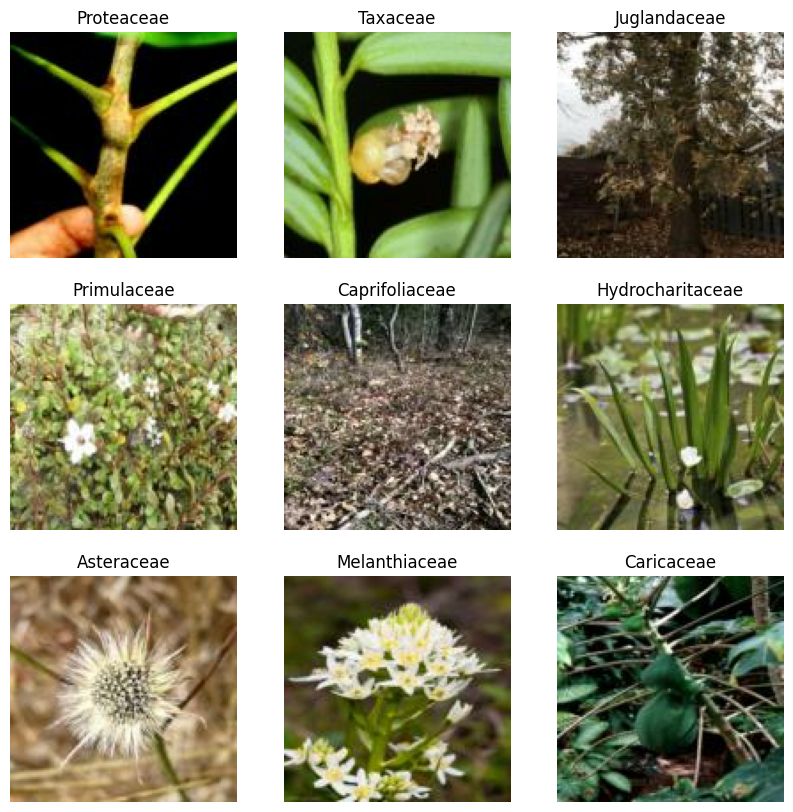

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 128, 128, 3)
(32,)


In [10]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.shuffle(1000).cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [11]:
"""with tf.device('/device:GPU:0'):"""
normalization_layer = layers.Rescaling(1./255)


In [12]:
"""with tf.device('/device:GPU:0'):"""
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
print(first_image)

0.0 1.0
tf.Tensor(
[[[0.08235294 0.21960786 0.        ]
  [0.09019608 0.227451   0.        ]
  [0.1254902  0.24705884 0.01568628]
  ...
  [0.29411766 0.33333334 0.3372549 ]
  [0.2901961  0.32941177 0.3254902 ]
  [0.2901961  0.32941177 0.3254902 ]]

 [[0.08627451 0.22352943 0.        ]
  [0.09019608 0.227451   0.        ]
  [0.12156864 0.24313727 0.01960784]
  ...
  [0.29411766 0.33333334 0.32941177]
  [0.2901961  0.32941177 0.3254902 ]
  [0.2901961  0.33333334 0.31764707]]

 [[0.09411766 0.21960786 0.        ]
  [0.09803922 0.21960786 0.        ]
  [0.1254902  0.2392157  0.02745098]
  ...
  [0.2901961  0.32941177 0.3254902 ]
  [0.2901961  0.33333334 0.31764707]
  [0.28627452 0.32941177 0.30588236]]

 ...

 [[0.05882353 0.10588236 0.02745098]
  [0.0627451  0.10980393 0.03137255]
  [0.07058824 0.11764707 0.03921569]
  ...
  [0.10588236 0.21960786 0.03921569]
  [0.09803922 0.21176472 0.03137255]
  [0.08627451 0.20000002 0.01960784]]

 [[0.03137255 0.08627451 0.        ]
  [0.03529412 0.09

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


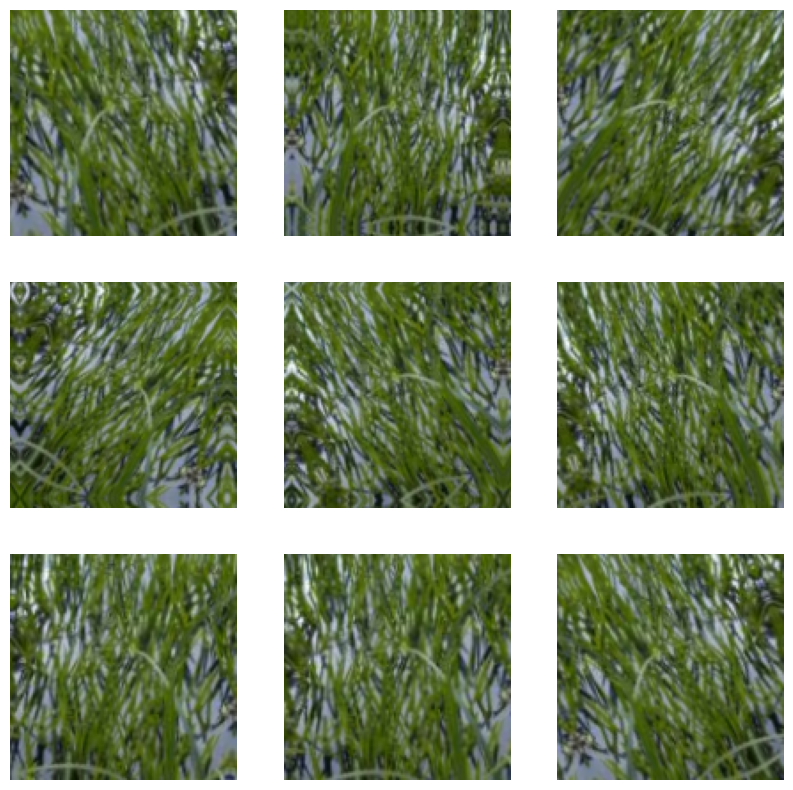

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [19]:
num_classes = len(class_names
                  )
def create_model():

  model = Sequential([
    data_augmentation,
    #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #layers.Dense(250, activation='relu'),
    #layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #layers.Dense(500, activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(1115, activation='relu'),
    layers.Dense(num_classes)
  ])

  #opt = SGD(learning_rate=1e-06, momentum=0.8)
  adam = Adam(learning_rate=1e-05)
  model.compile(optimizer=adam,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy', 'sparse_categorical_accuracy'])
  return model


In [20]:
with tf.device('/device:GPU:0'):
  model = create_model()
  model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)       

In [21]:
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
if (latest):
  print(latest)
  model.load_weights(latest)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=20*batch_size)


In [38]:
epochs=10

with tf.device('/device:GPU:0'):

  history = model.fit(
    normalized_ds,
    #train_ds,
    validation_data=normalized_val,
    epochs=epochs,
    callbacks=[cp_callback]
  )


Epoch 1/10
119/573 [=====>........................] - ETA: 41s - loss: 4.4413 - accuracy: 0.1100 - sparse_categorical_accuracy: 0.1100
Epoch 1: saving model to training_normalized/cp-0001.ckpt
573/573 [==============================] - 52s 91ms/step - loss: 4.4183 - accuracy: 0.1149 - sparse_categorical_accuracy: 0.1149 - val_loss: 5.0868 - val_accuracy: 0.0554 - val_sparse_categorical_accuracy: 0.0554
Epoch 2/10
186/573 [========>.....................] - ETA: 31s - loss: 4.4176 - accuracy: 0.1132 - sparse_categorical_accuracy: 0.1132
Epoch 2: saving model to training_normalized/cp-0002.ckpt
573/573 [==============================] - 52s 91ms/step - loss: 4.4002 - accuracy: 0.1167 - sparse_categorical_accuracy: 0.1167 - val_loss: 5.0920 - val_accuracy: 0.0539 - val_sparse_categorical_accuracy: 0.0539
Epoch 3/10
253/573 [============>.................] - ETA: 29s - loss: 4.3874 - accuracy: 0.1215 - sparse_categorical_accuracy: 0.1215
Epoch 3: saving model to training_normalized/cp-0003.

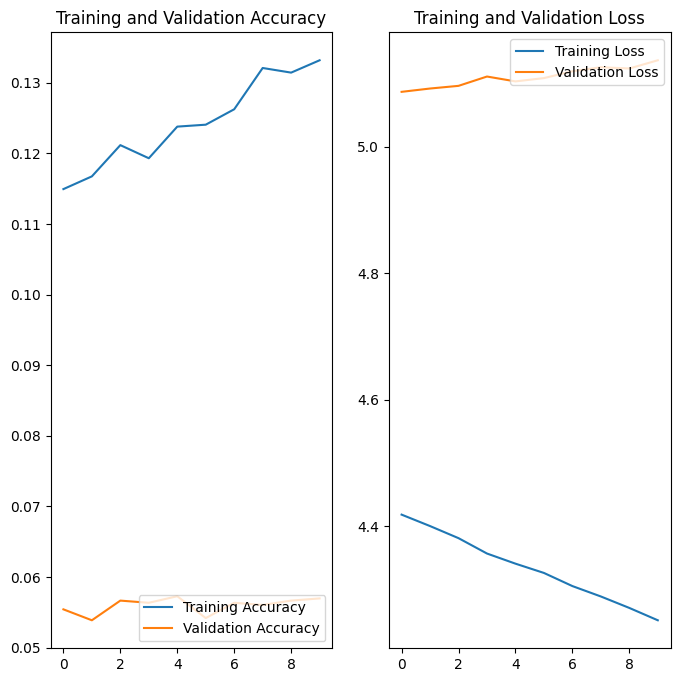

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


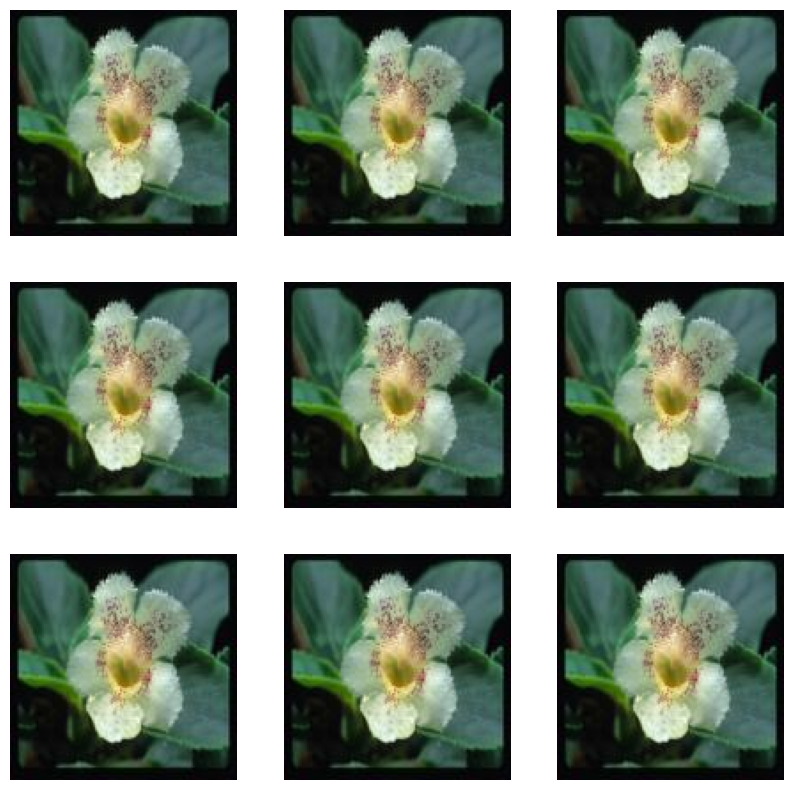

In [33]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [47]:
liste = []
sunflower_url = "https://4.bp.blogspot.com/_Nth8QgvmEAk/S_UZ_aRn87I/AAAAAAAAR-U/To_zRuvmjOE/s1600/lairis4.jpg"
#sunflower_url="https://live.staticflickr.com/3067/2470594217_acdbacdb46_b.jpg"
sunflower_url="https://i.pinimg.com/736x/aa/65/50/aa65506faede7e10ea86ee36ed8bc185.jpg"
#sunflower_url="http://www.snut.fr/wp-content/uploads/2015/12/image-de-love-2-1024x576.jpg"
sunflower_url="https://www.wallpapergeeks.com/wp-content/uploads/2014/02/Hybrid-Tea-Rose-Wallpaper.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


#sunflower_path = "oneimg/Acanthaceae/1050190484.jpg";
img = tf.keras.utils.load_img(
    "rose.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
normalized_array = img_array/255
#print(normalized_array)
img_array = normalized_array

img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(np.max(predictions))
print(predictions[0][0])
dic = dict()
i =0 
for pre in predictions[0]:
    if pre == np.max(predictions):
        dic[i] = pre
    i+=1
print(dic.keys())
print(list(dic)[0])
print(class_names[list(dic)[0]])

score = tf.nn.softmax(predictions)
#print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 20ms/step
4.8630915
1.124971
dict_keys([42])
42
Cannaceae
This image most likely belongs to Cannaceae with a 14.07 percent confidence.


In [ ]:
#model.save('saved_model/plants_classifiertest')